# Display

`plenoptic` contains a variety of code for visualizing the outputs and the process of synthesis. This notebook details how to make use of that code, which has largely been written with the following goals:
1. If you follow the model API (and that of `Synthesis`, if creating a new synthesis method), display code should plot something reasonably useful automatically.
2. The code is flexible enough to allow for customization for more useful visualizations.
3. If the plotting code works, the animate code should also.

In [7]:
import plenoptic as po
import torch

%matplotlib inline

## General

We include two wrappers of display code from `pyrtools`, adapting them for use with tensors. These `imshow` and `animshow`, which accept tensors of real- or complex-valued images or videos (respectively) and properly convert them to arrays for display purposes. These are not the most flexible functions (for example, `imshow` requires that real-valued tensors be 4d) but, assuming you follow our API, should work relatively painlessly. The main reason for using them (over the image-display code from `matplotlib`) is that we guarantee fidelity to image size: a value in the tensor corresponds to a pixel or an integer number of pixels in the image (if upsampling); if downsampling, we can only down-sample by factors of two. This way, you can be sure that any strange apperance of the image is not due to aliasing in the plotting.

For `imshow`, we require that real-valued tensors be 4d: `(batch, channel, height, width)`. If you're showing images, they're likely to be grayscale (in which case there's only 1 channel) or RGB(A) (in which case there's 3 or 4, depending on whether it includes the alpha channel). We plot grayscale images without a problem:

torch.Size([2, 1, 256, 256])


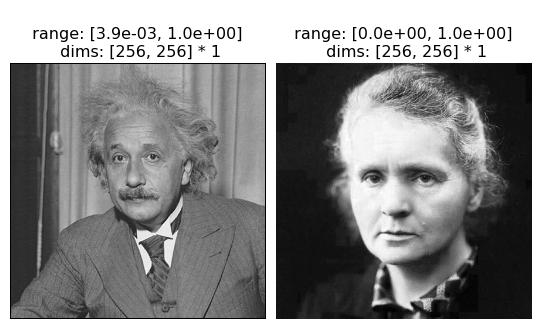

In [4]:
img = po.load_images(['../data/einstein.pgm', '../data/curie.pgm'])
print(img.shape)
fig = po.imshow(img)

We need to tell `imshow` that the image(s) are RGB in order for it to be plot correctly.

torch.Size([2, 3, 256, 256])


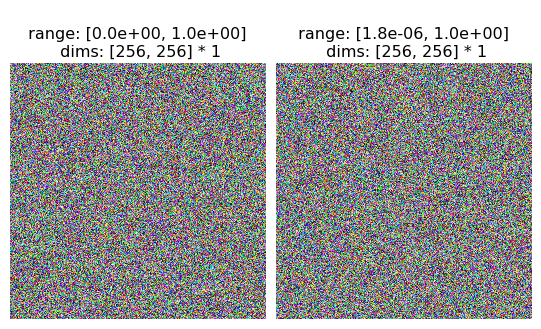

In [23]:
rgb = torch.rand(2, 3, 256, 256)
print(rgb.shape)
fig = po.imshow(rgb, as_rgb=True)

 This is because we don't want to assume that a tensor with 3 or 4 channels is always RGB. To pick a somewhat-contrived example, imagine the following steerable pyramid:

In [24]:
pyr = po.simul.Steerable_Pyramid_Freq(img.shape[-2:], downsample=False, height=1, order=2)

In [26]:
coeffs = pyr(img)
print(coeffs.shape)

torch.Size([2, 5, 256, 256])


The first and last channels are residuals, so if we only wanted to look at the coefficients, we'd do the following:

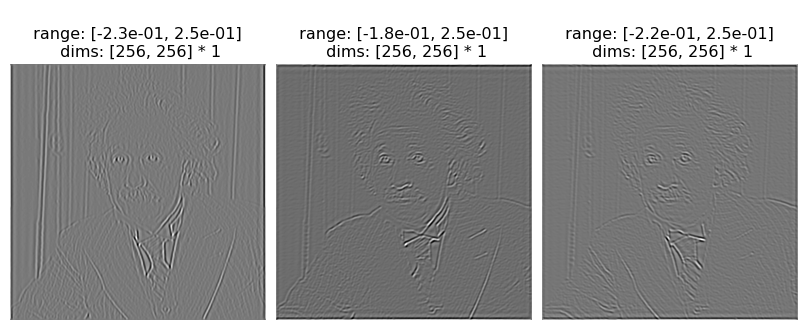

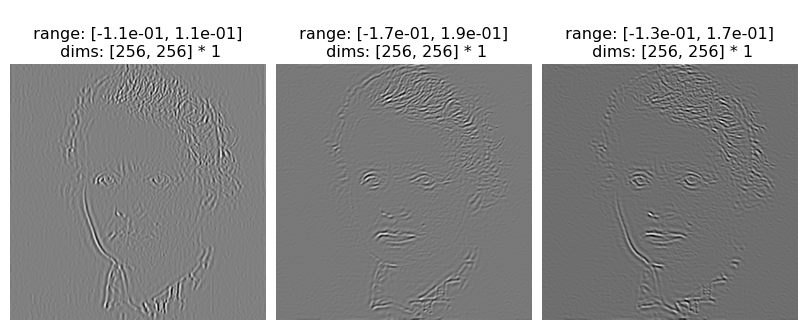

In [33]:
po.imshow(coeffs[:, 1:-1], batch_idx=0)
po.imshow(coeffs[:, 1:-1], batch_idx=1);

We really don't want to interpret those values as RGB.

Note that in the above `imshow` calls, we had to specify the `batch_idx`. This function expects a 4d tensor, but if it has more than one channel and more than one batch (and it's not RGB), we can't display everything. The user must therefore specify either `batch_idx` or `channel_idx`.

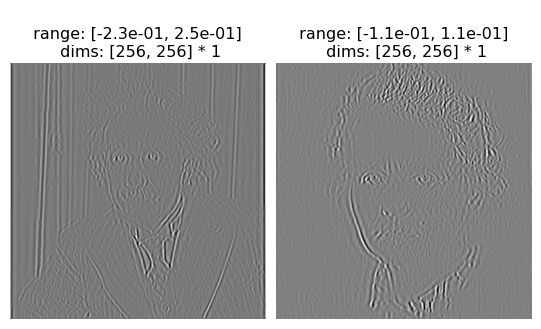

In [35]:
po.imshow(coeffs[:, 1:-1], channel_idx=0);

### COMPLEX TENSORS and PYRSHOW

after Nikhil makes the changes to steerable pyramid

`animshow` works analogously to `imshow`, wrapping around the `pyrtools` version but expecting a 5d tensor: `(batch, channel, time, height, width)`. It returns a `matplotlib.animation.FuncAnimation` object, which can be saved as an mp4 or converted to an html object for display in a Jupyter notebook

In [47]:
pyr = po.simul.Steerable_Pyramid_Freq(img.shape[-2:], downsample=False, height='auto', order=3)
coeffs = pyr(img)
print(coeffs.shape)
# because coeffs is 4d, we add a dummy dimension for the channel in order to make animshow happy
po.convert_anim_to_html(po.animshow(coeffs.unsqueeze(1), batch_idx=0))

torch.Size([2, 26, 256, 256])


## Synthesis-specific

Each synthesis method has a variety of display code to visualize the state and progress of synthesis, as well as to ease understanding of the process and look for ways to improve. For example, in metamer synthesis, it can be useful to determine what component of the model has the largest error.

In [50]:
img = po.load_images('../data/einstein.pgm')
rgc = po.simul.PooledRGC(.5, img.shape[-2:], window_type='gaussian', std_dev=1)
rep = rgc(img)

As long as your model returns a 3d or 4d vector (first two dimensions corresponding to `batch` and `channel`), then our plotting code should work automatically. If it returns a 3d representation, we plot a stem plot; if it's 4d, an image.

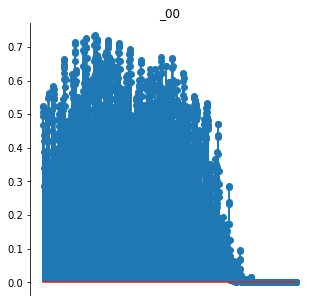

In [53]:
po.tools.display.plot_representation(data=rep);

In [63]:
met = po.synth.Metamer(img, rgc)
met.synthesize(max_iter=100, optimizer='Adam', );

100%|██████████| 100/100 [00:19<00:00,  5.03it/s, gradient_norm=9.5057e-02, learning_rate=0.01, loss=4.5653e-02, pixel_change=9.2262e-03]


/home/billbrod/Documents/plenoptic/plenoptic/tools/display.py:831: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")
/home/billbrod/Documents/plenoptic/plenoptic/simulate/models/ventral_stream.py:1052: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


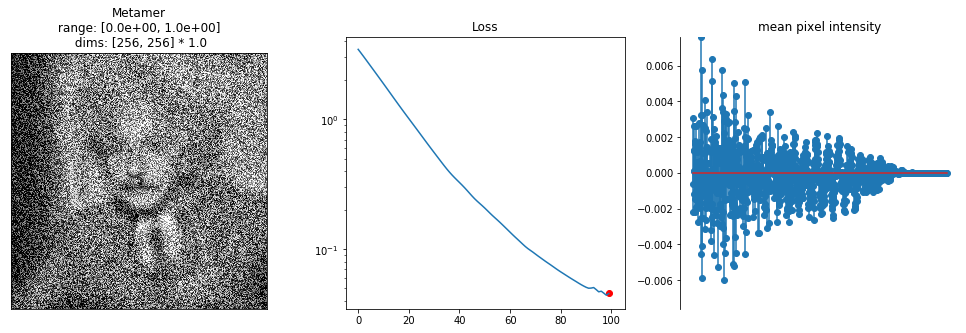

In [65]:
fig = met.plot_synthesis_status()

In [71]:
for ax in fig.axes:
    print(ax.)

[]
[]


While this provides a starting point, it's not always super useful. In the example above, the model returns the average pixel intensities in pooling windows across the image, and so plotting as a single stem plot is pretty decent. The representation of the model below, however, is the average energy at 4 scales and 4 orientations in pooling windows across the image. That structure is lost in a single stem plot:

/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling_windows.py:283: UserWarning: Creating windows for scale 1 with min_ecc 0.5, but calculated min_ecc is 0.7480167757526863, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "
/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling_windows.py:283: UserWarning: Creating windows for scale 2 with min_ecc 0.5, but calculated min_ecc is 1.4960335515053724, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "
/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling_windows.py:283: UserWarning: Creating windows for scale 3 with min_ecc 0.5, but calculated min_ecc is 2.9920671030107453, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "


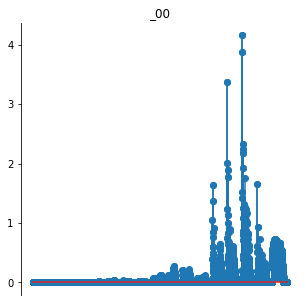

In [56]:
v1 = po.simul.PooledV1(.5, img.shape[-2:], window_type='gaussian', std_dev=1)
rep = v1(img)
po.tools.display.plot_representation(data=rep);

Trying to guess this advanced structure would be impossible for our generic plotting functions. However, if your model has a `plot_representation()` method, we can make use of it:

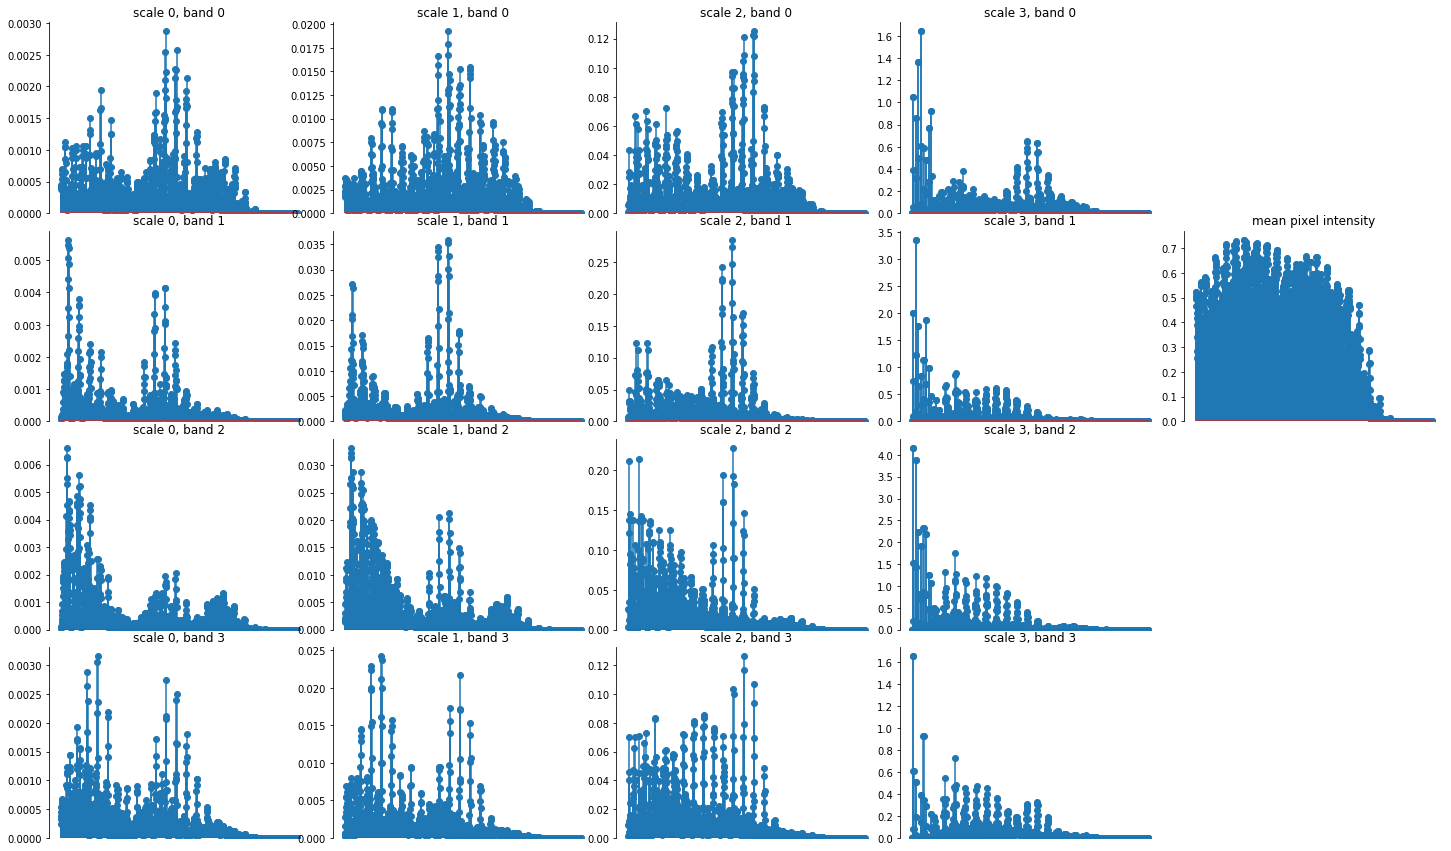

In [57]:
v1.plot_representation(data=rep);

Note how the plot below is the same as the one above. This might not seem very useful, but we make use of this in the plotting methods used by our synthesis classes.

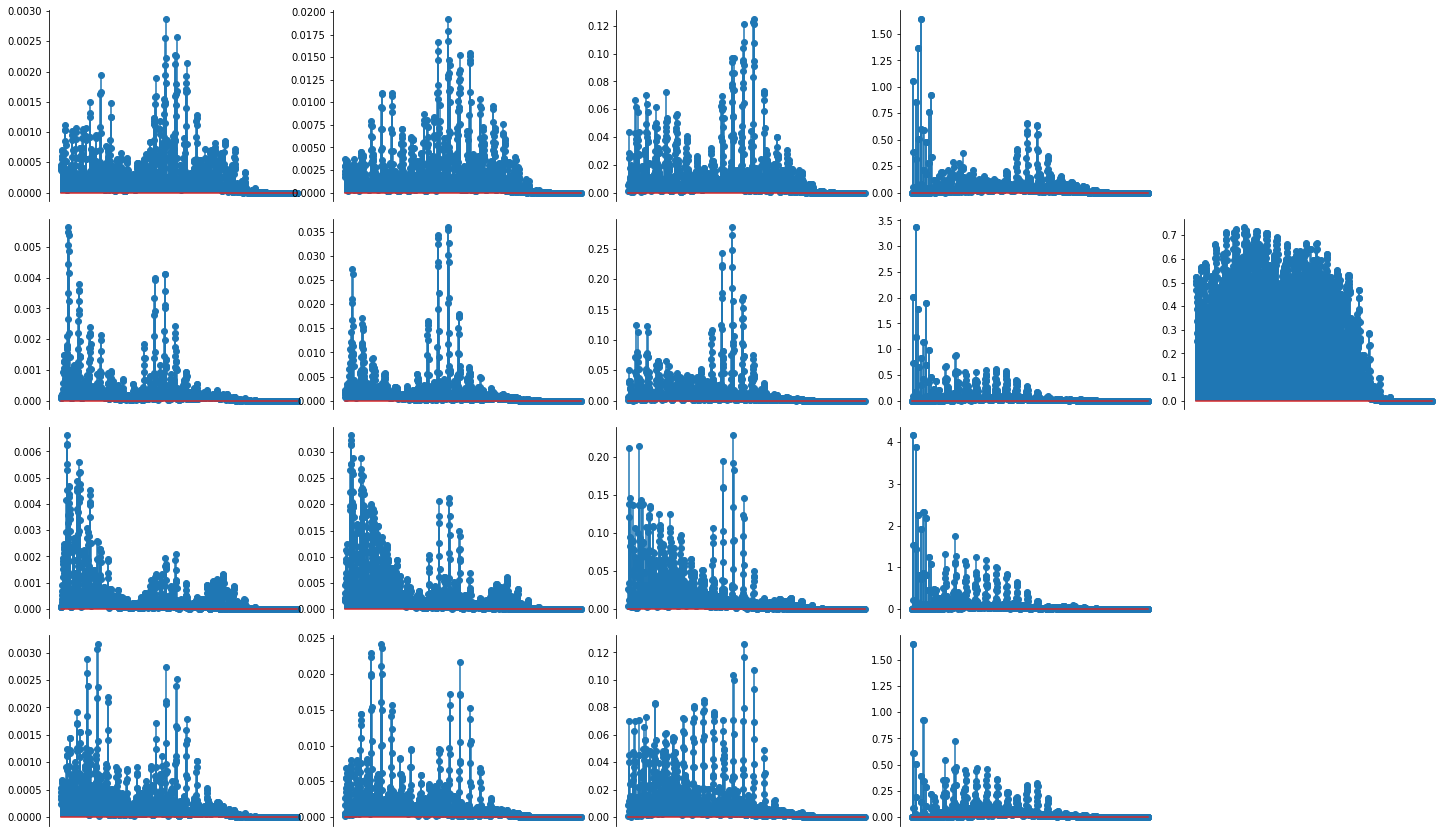

In [60]:
po.tools.display.plot_representation(v1, rep, figsize=(25, 15));

In [62]:
met = po.synth.Metamer(img, v1)
met.synthesize(max_iter=100, optimizer='Adam', coarse_to_fine='together');

 42%|████▏     | 42/100 [00:22<00:30,  1.87it/s, current_scale=mean_luminance, current_scale_loss=0.312, gradient_norm=2.2276e-01, learning_rate=0.01, loss=2.6293e+00, pixel_change=1.4174e-02]


KeyboardInterrupt: 

## Advanced